In [12]:
import copy
import os
import pickle
import sys
import time
sys.path.append('/home/diego/python/generative-glm/experiments/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
from torch.optim import Adam

from gglm.glm.cimmdglm import CIMMDGLM
from gglm.glm.torchglm import TorchGLM
from gglm.metrics import bernoulli_log_likelihood_poisson_process, MMD, time_rescale_transform
from gglm.utils import shift_array

from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues

from sptr.sptr import SpikeTrain

from signals import auto_covariance

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
server_name = os.uname()[1]

In [14]:
def plot_layout():
    fig = plt.figure(figsize=(12, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax03, ax10, ax11, ax20, ax21, ax30, ax40, ax41, ax42, ax43)

def plot_layout2():
    ncols = 3
    r1, r2 = 2, 1
    nrows = 3 * r1
    fig = plt.figure(figsize=(10, 10))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1)
#     ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), rowspan=r1, colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
#     ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax31 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, ncols - 1), rowspan=r1, colspan=1)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), colspan=ncols - 1)
#     ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
#     ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
#     ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    return fig, (ax00, ax01, ax02, ax10, ax11, ax20, ax30, ax31, ax40)

## load data

In [15]:
# idx = np.random.choice(mask_spikes.shape[1], size=mask_spikes.shape[1], replace=False)

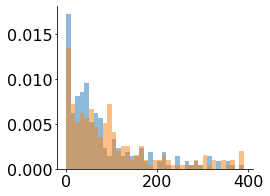

In [16]:
# path = "/home/diego/python/generative-glm/cool_stuff/p110509b_dots_mat_diego.h5"
path = "./huk_p110509b_dots.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)

# np.random.seed(1)
# mask_spikes = mask_spikes[:, np.random.choice(mask_spikes.shape[1], size=mask_spikes.shape[1], replace=False)]

t = np.arange(0, mask_spikes.shape[0], 1)
dt = 1

# offset = 100
# n_train = 100
# offset = 0
# n_train = 200
# n_val = 100

# offset = 400
# n_train = 200
# n_val = 200
# idx_train = np.arange(offset, offset + n_train)
# idx_val = np.arange(offset + n_train, offset + n_train + n_val)

# offset = 1
# idx_train = np.arange(0, 400, 2)
# idx_val = idx_train + 1

idx_train = np.arange(100, 200, 2)
idx_val = idx_train + 1

# n_train = 200
# n_val = 200
# idx = np.random.choice(mask_spikes.shape[1], size=n_train + n_val, replace=False)
# idx_train = idx[:n_train]
# idx_val = idx[n_train:]

st = SpikeTrain(t, mask_spikes)

# mask_spikes_train = mask_spikes[:, offset:offset + n_train]
# mask_spikes_val = mask_spikes[:, offset + n_train:offset + n_train + n_val]

mask_spikes_train = mask_spikes[:, idx_train]
mask_spikes_val = mask_spikes[:, idx_val]

n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocov_train = np.mean(auto_covariance(mask_spikes_train, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)


n_spk_val = np.sum(mask_spikes_val)
fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_val = -bernoulli_log_likelihood_poisson_process(mask_spikes_val)
autocov_val = np.mean(auto_covariance(mask_spikes_val, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)

st_val = SpikeTrain(t, mask_spikes_val)
isi_val = st_val.isi_distribution()
mean_isi_val = np.mean(isi_val)

bins_isi = np.arange(0, 400, 10)
fig, ax = plt.subplots()
ax.hist(isi_train, density=True, alpha=0.5, bins=bins_isi);
ax.hist(isi_val, density=True, alpha=0.5, bins=bins_isi);

In [17]:
# dic = dict(idx_train=idx_train, idx_val=idx_val)

# path = '/home/diego/storage/generative-glm/experiments/figure4/' + 'idx_data.pk'
# with open(path, "wb") as fit_file:
#     pickle.dump(dic, fit_file)

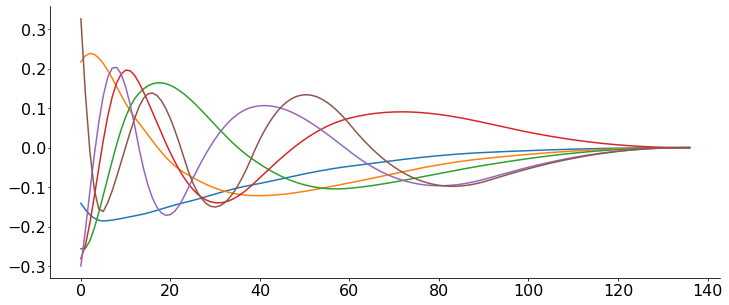

In [18]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

# n = 6
# last_peak = 400
# b = last_peak / 5

# n = 8
# last_peak = 300
# b = last_peak / 5

n = 6
last_peak = 60
b = last_peak / 5

peak0 = 0

yrnge = np.log(np.array([0, last_peak]) + b)
db = np.diff(yrnge) / (n - 1)
ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
mxt = np.exp(yrnge[1] + 2 * db) - b
t_ker = np.arange(0, mxt[-1] + dt, dt)
# t_ker = np.arange(0,)

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_ker, basis)

In [19]:
n_samples = 8000

## contents <a name="contents"></a>  

[ML](#ml)  
[CIMMD](#cimmd)  

### ML <a name="ml"></a>  
[contents](#contents)

In [52]:
def phi_mean_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T

def phi_var_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    fr = torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T
    mean_fr = torch.mean(fr)
    return (fr - mean_fr)**2

def phi_mean_var_fr(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    fr = torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T
    mean_fr = torch.mean(fr)
#     return (fr + 1)**2
    return torch.cat((fr, fr**2, fr**3, fr**4), 0)

def phi_mean_fr_log(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    return torch.log(torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T + 1e-20)

def phi_mean_fr_squared(t, mask_spikes):
    T = t[-1] - t[0] + t[1]
    fr = torch.sum(mask_spikes, 0).double()[None, :] * 1000 / T
    return fr + fr**2

def phi_cum(t, mask_spikes):
    cum = torch.cumsum(mask_spikes.double(), dim=0)
    return cum

def phi_autocov(t, mask_spikes, argf=200):
    autocor = auto_covariance(mask_spikes.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor = torch.from_numpy(autocor[:argf])
    return autocor

def ker_autocov(t, mask_spikes1, mask_spikes2):
    autocor1 = auto_covariance(mask_spikes1.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor1 = torch.from_numpy(autocor1[:250])
    autocor2 = auto_covariance(mask_spikes2.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor2 = torch.from_numpy(autocor2[:250])
#     print(autocor)
#     print(autocor.shape)
#     print(knkww)
#     autocov = conv1d(eta.T[None, :, :], eta.T[:, None, :], padding=padding, groups=eta.shape[1]) / T
#     autocov = autocov[0, :, (padding-1):].T
    return torch.sum(autocor1[:, :, None] * autocor2[:, None, :], dim=0)

def ker_expautocov(t, mask_spikes1, mask_spikes2):
    autocor1 = auto_covariance(mask_spikes1.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor1 = torch.from_numpy(autocor1[:250])
    autocor2 = auto_covariance(mask_spikes2.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor2 = torch.from_numpy(autocor2[:250])
    gramian = torch.exp(-torch.sum((autocor1[:, :, None] - autocor2[:, None, :])**2, dim=0) / sd2)
#     print(torch.sum((autocor1[:, :, None] - autocor2[:, None, :])**2, dim=0))
#     print(gramian)
#     print(kwknwk)
    return gramian

def ker_muisi(t, mask_spikes1, mask_spikes2):
    isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
    isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
    isi1 = torch.tensor([np.mean(_isi) if len(_isi) > 0 else t[-1] for _isi in isi1])
    isi2 = torch.tensor([np.mean(_isi) if len(_isi) > 0 else t[-1] for _isi in isi2])
    return isi1[:, None] * isi2[None, :]

def ker_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    return fr1[:, None] * fr2[None, :]

def ker_var_fr(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    mean_fr1 = torch.mean(fr1)
    mean_fr2 = torch.mean(fr2)
    return (fr1 - mean_fr1)[:, None]**2 * (fr2 - mean_fr2)[None, :]**2

def ker_expfr(t, mask_spikes1, mask_spikes2, sd2=1e4):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
#     gramian = torch.exp(-torch.sum((fr1[:, None] - fr2[None, :])**2, 0) / sd2)
    gramian = torch.exp(-(fr1[:, None] - fr2[None, :])**2 / sd2)
    return gramian

def ker_expfr_sum(t, mask_spikes1, mask_spikes2, sd2s=(1e6,)):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    diff_fr = (fr1[:, None] - fr2[None, :])**2
#     gramian = torch.exp(-diff_cum / 5e5)
    gramian = torch.exp(-diff_fr / sd2s[0]) * sd2s[0]
    for sd2 in sd2s[1:]:
        gramian = gramian + torch.exp(-diff_fr / sd2) * sd2
#     gramian += torch.exp(-(fr1[:, None] - fr2[None, :])**2 / 5e3)
#     gramian += torch.exp(-(fr1[:, None] - fr2[None, :])**2 / 5e1)
    return gramian

def ker_expfrautocov(t, mask_spikes1, mask_spikes2):
    T = t[-1] - t[0] + t[1]
    fr1 = torch.sum(mask_spikes1, 0).double() * 1000 / T
    fr2 = torch.sum(mask_spikes2, 0).double() * 1000 / T
    autocor1 = auto_covariance(mask_spikes1.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor1 = torch.from_numpy(autocor1[:250])
    autocor2 = auto_covariance(mask_spikes2.numpy(), subtract_mean=False, stationary_signal=False, biased=False)
    autocor2 = torch.from_numpy(autocor2[:250])
    gramian = 1e4 * torch.exp(-torch.sum((fr1[:, None] - fr2[None, :])**2, 0) / 1e7) + \
              1e6 * torch.exp(-torch.sum((autocor1[:, :, None] - autocor2[:, None, :])**2, dim=0) / 1e-3)
    return gramian

def ker_sch_heavi(t, mask_spikes1, mask_spikes2, sd2s=(1e6,)):
    cum1 = torch.cumsum(mask_spikes1, dim=0)
    cum2 = torch.cumsum(mask_spikes2, dim=0)
    diff_cum = torch.sum((cum1[:, :, None] - cum2[:, None, :])**2, dim=0)
#     diff_cum = torch.sum(torch.abs(cum1[:, :, None] - cum2[:, None, :]), dim=0)
    gramian = torch.exp(-diff_cum / sd2s[0]) * sd2s[0]
    for sd2 in sd2s[1:]:
        gramian = gramian + torch.exp(-diff_cum / sd2) * sd2
    return gramian

dic_ker_strings = {'phi_mean_fr': "fr*fr'", 'phi_mean_fr_squared': "fr^2*fr^2'", 'phi_mean_fr_log': "logfr*logfr'",
                   "phi_var_fr": "(fr**2-mean(fr))*(fr'**2-mean(fr'))",
                   'ker_fr': "fr*fr'", 'ker_expfr': "exp(-(fr - fr')^2 / sd2)", 'ker_expfr_sum': "exp(-(fr - fr')^2 / sd2)", 'phi_autocov': 's*s', 
                  'ker_sch_heavi': 'exp(-sum((cum1 - cum2)^2 / sd2)', 'ker_autocov': 's*s', 'ker_muisi': 'muisi', 
                  'ker_expautocov': "exp(-(C - C')^2 / sd2)", 
                  'ker_expfrautocov': "exp(-(C - C')^2 / sd2) + samewithfr"}
dic_ker_name = {'phi_mean_fr': "product", 'phi_mean_fr_squared': 'product_squared', 'phi_mean_fr_log': 'product_logs',
                "phi_var_fr": "product_minus_mean_squared", 
                'ker_fr': 'product', 'ker_expfr': "gaussian_fr", 'ker_expfr_sum': "gaussian_fr", 'phi_autocov': 'autocov', 
               'ker_sch_heavi': 'schoenberg', 'ker_autocov': 'autocov', 'ker_muisi': 'muisi', 
               'ker_expautocov': 'gaussian_autocov', 
               'ker_expfrautocov': "gaussian_fr_autocov"}

phi, kernel = None, ker_sch_heavi

def fun_metrics_ml(model, t, mask_spikes, X, n_batch_fr=None):
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    u_dc_val, r_dc_val = model.sample_conditioned(st_val.t, st_val.mask)
    nll_val = -(np.sum(np.log(1 - np.exp(-dt * r_dc_val[st_val.mask]) + 1e-24) ) - \
                dt * np.sum(r_dc_val[~st_val.mask]))
    u_fr, r_fr, mask_spikes_fr = model.sample(st_train.t, shape=(n_batch_fr,))
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    mmd = MMD(t, torch.from_numpy(st_val.mask), torch.from_numpy(mask_spikes_fr), phi=phi, kernel=kernel, biased=True)
    return dict(mu_fr=mu_fr, nll_val=nll_val, mmd=mmd)

In [53]:
coefs = np.zeros(basis.shape[1])
eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=coefs)

lr = 1e-1
num_epochs = 200
metrics_kwargs = dict(n_batch_fr=8000)
n_metrics = 1

glm = TorchGLM(u0=-5, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=fun_metrics_ml, metrics_kwargs=metrics_kwargs, 
                                n_metrics=n_metrics)
loss_ml = np.array(loss_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_train_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk_train
nll_normed_val_ml = (metrics_ml['nll_val'] - nll_pois_proc_val) / np.log(2) / n_spk_val

_, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask)
_, r_val_dc_ml = glm.sample_conditioned(st_val.t, st_val.mask)
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_val.t, shape=(n_samples,))
fr_ml = np.sum(mask_spikes_fr_ml, 0) / (mask_spikes_fr_ml.shape[0] * dt) * 1000

st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
isi_fr_ml = st_fr_ml.isi_distribution()
mean_isi_fr_ml = np.mean(isi_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)
autocov_ml = np.mean(auto_covariance(mask_spikes_fr_ml, method='fft', subtract_mean=False, stationary_signal=False, biased=False), 1)
autocov_mse_ml = np.mean((autocov_ml[1:150] - autocov_val[1:150])**2)

z_ml_train, ks_ml_train = time_rescale_transform(dt, st_train.mask, r_train_dc_ml)
values, bins_ks = np.histogram(np.concatenate(z_ml_train), bins=200)
z_cum_ml_train = np.append(0., np.cumsum(values) / np.sum(values))

z_ml_val, ks_ml_val = time_rescale_transform(dt, st_val.mask, r_val_dc_ml)
values, _ = np.histogram(np.concatenate(z_ml_val), bins=bins_ks)
z_cum_ml_val = np.append(0., np.cumsum(values) / np.sum(values))

 epoch 199 of 200 loss 1709.3181

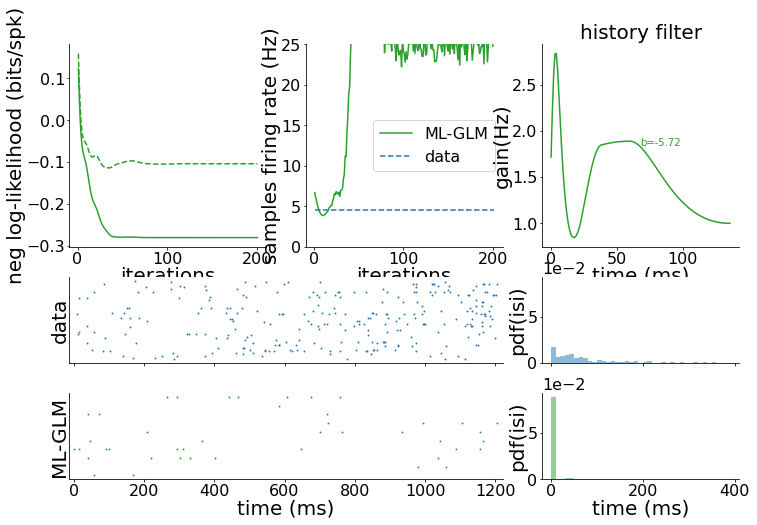

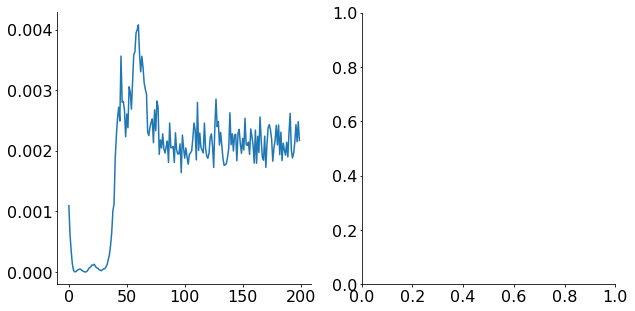

In [54]:
for key, val in metrics_ml.items():
    metrics_ml[key] = np.array(val)

ms = 0.9
    
r1 = 2
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=r1)
ax2 = plt.subplot2grid((4, 3), (0, 1), rowspan=r1)
ax3 = plt.subplot2grid((4, 3), (0, 2), rowspan=r1)
ax4 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax5 = plt.subplot2grid((4, 3), (2, 2), colspan=1)
ax6 = plt.subplot2grid((4, 3), (3, 0), colspan=2, sharex=ax4)
ax7 = plt.subplot2grid((4, 3), (3, 2), colspan=1, sharex=ax5, sharey=ax5)

ax1.plot(iterations_ml, nll_normed_train_ml, color=palette['ml'])
ax1.plot(iterations_ml[::n_metrics], nll_normed_val_ml, '--', color=palette['ml'])
myplt.set_labels(ax1, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax2.plot(iterations_ml[::n_metrics], metrics_ml['mu_fr'], '-', label='ML-GLM', color=palette['ml'])
ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
ax2.set_ylim(0, 25)
myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
ax2.legend()

glm.eta.plot(t=t_ker, ax=ax3, exp_values=True, color=palette['ml'])
myplt.set_labels(ax3, xlabel='time (ms)', ylabel='gain(Hz)', title='history filter')
ax3.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax3.transAxes)
# ax3.set_ylim(-0.4, 0.2)

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
st_train.plot(ax=ax4, ms=ms, color=palette['d'])
# st_val.plot(ax=ax4, ms=0.7, color=palette['d'])
ax4.tick_params(axis='both', labelbottom=False, labelleft=False)
ax4.set_yticks([])
# ax4.set_xlabel(None)
ax4.set_ylabel('data')

bins = np.arange(0, 4600, 200)
ax5.hist(isi_train, density=True, color=palette['d'], label='data', alpha=0.5, bins=bins_isi)
ax5.set_ylabel('pdf(isi)')
ax5.tick_params(axis='both', labelbottom=False)

# st_fr_ml.plot(ax=ax5, ms=0.7, color=palette['ml'])
st_fr_ml.sweeps(np.arange(10)).plot(ax=ax6, ms=ms, color=palette['ml'])
myplt.set_labels(ax6, xlabel='time (ms)', ylabel='ML-GLM')
ax6.set_yticks([])

ax7.hist(isi_fr_ml, density=True, color=palette['ml'], label='ML-GLM', alpha=0.5, bins=bins_isi)
myplt.set_labels(ax7, xlabel='time (ms)', ylabel='pdf(isi)')
ax7.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig.subplots_adjust(hspace=0.35)
# fig.savefig('/home/diego/Dropbox/generative_glm/figures/human_ctx/human_ctx_ML.pdf', transparent=True)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(metrics_ml['mmd'], '-')

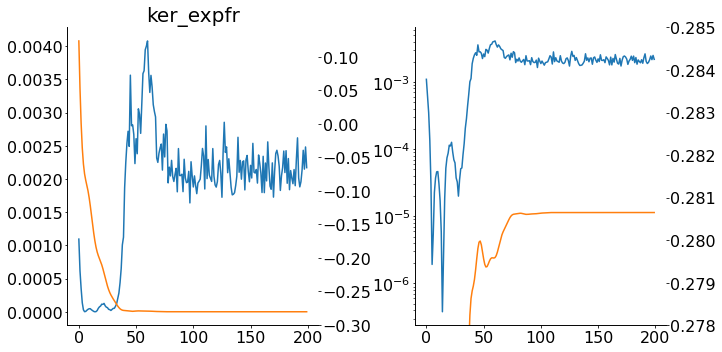

In [58]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(metrics_ml['mmd'], '-')
ax1b = ax1.twinx()
ax1b.plot(nll_normed_train_ml, 'C1')
if phi is not None:
    ker_name = phi.__name__
    ax1.set_title(phi.__name__)
else:
    ker_name = kernel.__name__
    ax1.set_title(ker_name)

ax2.plot(metrics_ml['mmd'], '-')
ax2b = ax2.twinx()
ax2b.plot(-nll_normed_train_ml, 'C1')
ax2b.set_ylim(0.278, 0.285)

ax2.set_yscale('log')
# ax2b.set_yscale('log')

fig.tight_layout()
fig.savefig('./mmd_while_ml/' + ker_name + '.png')